<a href="https://colab.research.google.com/github/g40rgeLE/ml_from_scratch/blob/main/Logistics_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logisits Regression#
$z = (\vec{\omega}, \vec{x})$, $x_0 = 1$ $∀\vec{x}$.\
То, что мы записали здесь под z называтся логитом (абсолютное значение). Для перевода логита в относительную величину, смысл которой вероятность принадлежности к положительному классу, нужно воспользоваться функцией, которая называется **сигмоидой**:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print('Setup complete')

Setup complete


<Axes: title={'center': 'Sigmoid'}, xlabel='z', ylabel='$\\sigma$'>

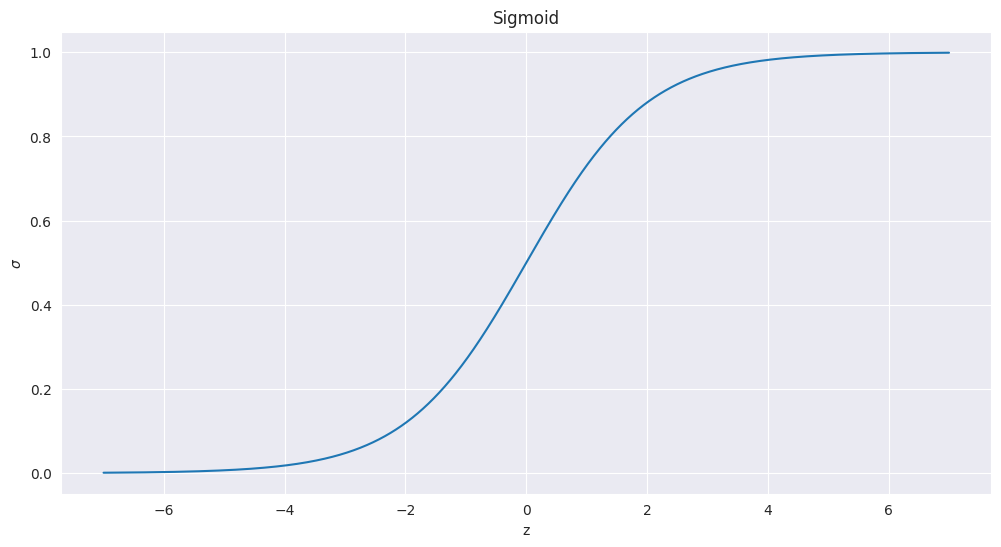

In [ ]:
def sigmoid(z_min: float = -5., z_max: float = 5, dz: float = 1e-3):
    z_arr = np.linspace(z_min, z_max, int((z_max - z_min) / dz) + 1)
    sigmoid_value = 1 / (1 + np.exp(-z_arr))
    return sigmoid_value, z_arr

f, z = sigmoid(-7, 7, 1e-2)

plt.figure(figsize=(12, 6))
plt.title('Sigmoid')
plt.xlabel('z')
plt.ylabel(r'$\sigma$')

sns.set_style('darkgrid')
sns.lineplot(x=z, y=f)

Как видим, для сигмоиды справедливы два свойства, которые нам необходимы для адекватной классификации:

* В отрицательной области получаем вероятность положительного класса меньше 0.5, т.е. объект принадлежит отрицательному классу;
* Чем больше расстояние от точки до разделяющей гиперплоскости, тем больше уверенности в предсказании модели.

##Функция потерь##
Для решения задачи логистической регрессии используется функция потерь Binary Cross Entropy:
$$Loss = -\frac{1}{N} \sum_{i = 1}^{N} [y_i log(p_i) + (1-y_i) log(1-p_i)]$$
Вычислим градиент от функции потерь:
$$∇(Loss) = \frac{1}{N} (\hat{Y} - Y) X$$

In [ ]:
#Logistics Regression class

class MyLogReg():

    def __init__(
            self,
            n_iter: int = 10,
            learning_rate: float = 0.1,
            metric: str = None,
            reg: str = None,
            l1_coef: float = 0.,
            l2_coef: float = 0.,
            sgd_sample = None,
            random_state: int = 42
            ):

        self.n_iter = n_iter
        self.learning_rate = learning_rate
        #accuracy, precision, recall, f1, roc_auc
        self.metric = metric
        #l1, l2, elasticnet
        self.reg = reg
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.sgd_sample = sgd_sample
        self.random_state = random_state

        self.score = None
        self.weights = None

    def __str__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return f'MyLogReg class: ' + ', '.join(params)

    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return f'MyLogReg class: ' + ', '.join(params)

    @staticmethod
    def _accuracy(y_true: np.array, y_proba: np.array):
        N = y_true.shape[0]
        y_pred = np.ones(N, dtype=np.int64) * (y_proba > 0.5)
        return (y_true == y_pred).sum() / y_true.shape[0]

    @staticmethod
    def _precision(y_true: np.array, y_proba: np.array):
        N = y_true.shape[0]
        y_pred = np.ones(N, dtype=np.int64) * (y_proba > 0.5)
        tp = (y_true * y_pred).sum()
        fp = ((1 - y_true) * y_pred).sum()
        return tp / (tp + fp)

    @staticmethod
    def _recall(y_true: np.array, y_proba: np.array):
        N = y_true.shape[0]
        y_pred = np.ones(N, dtype=np.int64) * (y_proba > 0.5)
        tp = (y_true * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()
        return tp / (tp + fn)

    @staticmethod
    def _f1(y_true: np.array, y_proba: np.array):
        recall = MyLogReg._recall(y_true, y_proba)
        precision = MyLogReg._precision(y_true, y_proba)
        return 2 * recall * precision / (recall + precision)

    @staticmethod
    def _roc_auc(y_true: np.array, y_proba: np.array):
        double_sum = 0
        P = y_true.sum()
        N = (1 - y_true).sum()
        for i in range(y_true.shape[0]):
            for j in range(y_true.shape[0]):
                double_sum += (y_true[i] < y_true[j]) * \
                 ((y_proba[i] < y_proba[j]) + 0.5 * (y_proba[i] == y_proba[j]))
        return 1/(P * N) * double_sum

    def l1(self):
        loss_reg = self.l1_coef * np.abs(self.weights).sum()
        grad_reg = self.l1_coef * np.sign(self.weights)
        return loss_reg, grad_reg

    def l2(self):
        loss_reg = self.l2_coef * np.power(self.weights, 2).sum()
        grad_reg = self.l2_coef * 2 * self.weights
        return loss_reg, grad_reg

    def elasticnet(self):
        l1_loss, l1_grad = self.l1()
        l2_loss, l2_grad = self.l2()
        return l1_loss + l2_loss, l1_grad + l2_grad

    @staticmethod
    def _loss_calc_(y_true: np.array, y_pred: np.array):
        N = y_true.shape[0]
        eps = 1e-15

        #Binary Cross Entropy
        loss = -1 / N * (y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps)).sum()
        return loss

    @staticmethod
    def _grad_calc_(y_true: np.array, y_pred: np.array, X: np.array, idx: np.array):
        N = y_true[idx].shape[0]

        #Gradient of LogLoss
        grad = 1 / N *  (y_pred[idx] - y_true[idx]) @ X[idx, :]
        return grad

    def get_coef(self):
        return self.weights[1:]

    def get_best_score(self):
        return self.score

    def fit(self, X: pd.DataFrame, y: pd.Series, verbose=False):
        np.random.seed(self.random_state)
        N, M = X.shape
        X_train = X.to_numpy()
        y_train = y.to_numpy()
        X_train = np.concatenate((np.ones((N, 1)), X_train), axis=1)

        self.weights = np.ones(M+1)

        for i in range(1, self.n_iter + 1):
            idx_batch = np.arange(0, N)
            if (self.sgd_sample):
                if isinstance(self.sgd_sample, int):
                    idx_batch = np.random.choice(idx_batch, self.sgd_sample,
                                                replace=False)
                if isinstance(self.sgd_sample, float):
                    idx_batch = np.random.choice(idx_batch,
                                                round(N * self.sgd_sample),
                                                replace=False)
            z = X_train @ self.weights
            y_hat = 1 / (1 + np.exp(-z))

            loss_reg, grad_reg = 0., 0.
            if self.reg:
                loss_reg, grad_reg = getattr(self, self.reg)()

            loss = self._loss_calc_(y_train, y_hat) + loss_reg
            grad = self._grad_calc_(y_train, y_hat, X_train, idx_batch) + grad_reg

            if isinstance(self.learning_rate, (int, float)):
                self.weights -= self.learning_rate * grad
            else:
                self.weights -= self.learning_rate(i) * grad

            #logs
            if verbose and i % verbose == 0:
                if self.metric:
                    self.score = getattr(self, '_' + self.metric)(y_train, y_hat)
                    print(f'{i} | loss: {loss} | {self.metric}: {self.score}')
                else:
                    print(f'{i} | loss: {loss}')

        z = X_train @ self.weights
        y_hat = 1 / (1 + np.exp(-z))
        if self.metric:
            self.score = getattr(self, '_' + self.metric)(y_train, y_hat)


    def predict_proba(self, X: np.array):
        N, _ = X.shape
        X_train = X.to_numpy()
        X_train = np.concatenate((np.ones((N, 1)), X_train), axis=1)

        z = X_train @ self.weights
        y_proba = 1 / (1 + np.exp(-z))
        return y_proba

    def predict(self, X: np.array):
        N, _ = X.shape
        y_proba = self.predict_proba(X)
        y_pred = np.ones(N, dtype=np.int64) * (y_proba > 0.5)
        return y_pred

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=14, n_informative=10, random_state=42)
X = pd.DataFrame(X)
y = pd.Series(y)
X.columns = [f'col_{col}' for col in X.columns]

In [ ]:
log_model = MyLogReg(n_iter = 1000, learning_rate=0.1)
log_model.fit(X, y, verbose = 100)

start | loss: 3.673688687661553
100 | loss: 0.4137804063166351
200 | loss: 0.36369005059686427
300 | loss: 0.35728756553070856
400 | loss: 0.35616306471318127
500 | loss: 0.3558553363014199
600 | loss: 0.35575208841645406
700 | loss: 0.35571499933139594
800 | loss: 0.3557013382783982
900 | loss: 0.3556962512551962
1000 | loss: 0.35569434655695503


In [ ]:
log_model.predict(X).sum()

515